# Random Forest PyTorch with MNIST 1000
- **Task**: Classification
- **Data**: MNIST 1000 Dataset
- **Model**: Random Forest
- **Criterion**: Entropy

In [1]:
!pip install -q watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.0 MB/s eta 0:00:00


In [2]:
%load_ext watermark
%watermark -a 'Nguyen Van Sy Thinh' -v -p torch

Author: Nguyen Van Sy Thinh

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

torch: 2.3.0+cu121



## 1. Import Library

In [3]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
import numpy as np
from typing import List
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Data

### 2.1. MNIST Dataset

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading training data
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)
# Loading test data
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 113785414.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 20222987.28it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 20864683.33it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1127784.09it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### 2.2. Data Information

In [5]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 60000
Number of testing samples: 10000


In [6]:
print(f"Datatype of the 1st training sample: {train_dataset[0][0].type()}")
print(f"Size of the 1st training sample: {train_dataset[0][0].size()}")

Datatype of the 1st training sample: torch.FloatTensor
Size of the 1st training sample: torch.Size([1, 28, 28])


### 2.3. Data Visualization

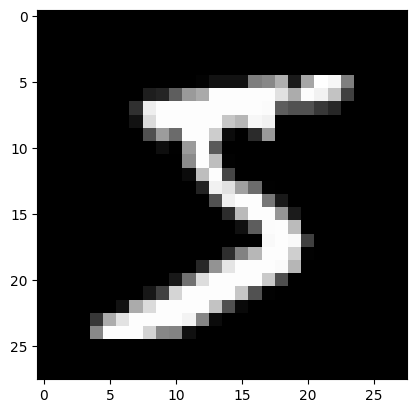

In [7]:
img_5 = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(img_5, cmap='gray')
plt.show()

### 2.4. Subset the Dataset

In [8]:
# Subset the dataset
subset_train_size = 500  # Number of samples to use for training
subset_test_size = 200  # Number of samples to use for testing

train_indices = np.random.choice(len(train_dataset), subset_train_size, replace=False)
test_indices = np.random.choice(len(test_dataset), subset_test_size, replace=False)

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
test_subset = torch.utils.data.Subset(test_dataset, test_indices)

In [9]:
# Data loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=subset_train_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=subset_test_size, shuffle=False)

# Extract data and labels
train_data, train_labels = next(iter(trainloader))
test_data, test_labels = next(iter(testloader))

# Flatten the images for the Decision Tree input
train_data = train_data.view(subset_train_size, -1)
test_data = test_data.view(subset_test_size, -1)

In [10]:
print(f"Number of training samples: {train_data.shape[0]}")
print(f"Number of testing samples: {test_data.shape[0]}")
print(f"Size of the 1st training sample: {train_data[0].size()}")
print(f"Size of the 1st testing sample: {test_data[0].size()}")

Number of training samples: 500
Number of testing samples: 200
Size of the 1st training sample: torch.Size([784])
Size of the 1st testing sample: torch.Size([784])


## 3. Model

### 3.1. Decision Node

In [11]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

### 3.2. Decision Tree Classifier

In [12]:
class DecisionTree:
    def __init__(self, depth=10, min_samples_split=2):
        self.depth = depth
        self.min_samples_split = min_samples_split
        self.tree = {}

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        if num_samples >= self.min_samples_split and depth <= self.depth:
            best_split = self._best_split(X, y, num_samples, num_features)
            if best_split["info_gain"] > 0:
                left_tree = self._build_tree(best_split["X_left"], best_split["y_left"], depth + 1)
                right_tree = self._build_tree(best_split["X_right"], best_split["y_right"], depth + 1)
                return Node(best_split["feature_index"], best_split["threshold"], left_tree, right_tree)

        leaf_value = self._calculate_leaf_value(y)
        return Node(value=leaf_value)

    def _best_split(self, X, y, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = torch.unique(feature_values)
            for threshold in possible_thresholds:
                X_left, y_left, X_right, y_right = self._split(X, y, feature_index, threshold)
                if len(X_left) > 0 and len(X_right) > 0:
                    info_gain = self._information_gain(y, y_left, y_right)
                    if info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["X_left"] = X_left
                        best_split["y_left"] = y_left
                        best_split["X_right"] = X_right
                        best_split["y_right"] = y_right
                        best_split["info_gain"] = info_gain
                        max_info_gain = info_gain
        return best_split

    def _split(self, X, y, feature_index, threshold):
        left_indices = torch.where(X[:, feature_index] <= threshold)[0]
        right_indices = torch.where(X[:, feature_index] > threshold)[0]
        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]
        return X_left, y_left, X_right, y_right

    def _information_gain(self, y, y_left, y_right):
        weight_left = len(y_left) / len(y)
        weight_right = len(y_right) / len(y)
        gain = self._entropy(y) - (weight_left * self._entropy(y_left) + weight_right * self._entropy(y_right))
        return gain

    def _entropy(self, y):
        class_labels = torch.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(torch.where(y == cls)[0]) / len(y)
            if p_cls > 0:
                entropy += -p_cls * torch.log2(torch.tensor(p_cls, dtype=torch.float32))
        return entropy

    def _calculate_leaf_value(self, y):
        return torch.mode(y)[0].item()

    def predict(self, X):
        predictions = [self._make_prediction(x, self.tree) for x in X]
        return predictions

    def _make_prediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self._make_prediction(x, tree.left)
        else:
            return self._make_prediction(x, tree.right)

### 3.3. Random Forest Classifier

In [13]:
class RandomForest:
    def __init__(self, n_trees=10, depth=10, min_samples_split=2):
        self.n_trees = n_trees
        self.depth = depth
        self.min_samples_split = min_samples_split
        self.trees: List[DecisionTree] = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            bootstrap_X, bootstrap_y = self._bootstrap_sample(X, y)
            tree = DecisionTree(depth=self.depth, min_samples_split=self.min_samples_split)
            tree.fit(bootstrap_X, bootstrap_y)
            self.trees.append(tree)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return [torch.mode(torch.tensor(tree_predictions[:, i]))[0].item() for i in range(X.shape[0])]

## 4. Fit model

In [14]:
tree = RandomForest(n_trees=5, depth=10, min_samples_split=10)
tree.fit(train_data, train_labels)

## 5. Inference

### 5.1. Scratch Model

In [20]:
# Predict on test data
test_predictions = tree.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy of Decision Tree from Scratch on subset of MNIST test data: {accuracy * 100:.2f}%')

Accuracy of Decision Tree from Scratch on subset of MNIST test data: 73.00%


### 5.2. scikit-learn RandomForestClassifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Train Decision Tree model
random_forest = RandomForestClassifier(n_estimators=5, max_depth=10, min_samples_split=10)
random_forest.fit(train_data, train_labels)

# Predict on test data
test_predictions = random_forest.predict(test_data)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_predictions)

print(f'Accuracy of Decision Tree from Sklearn library on subset of MNIST test data: {accuracy * 100:.2f}%')

Accuracy of Decision Tree from Sklearn library on subset of MNIST test data: 74.50%


## 6. Conclusion
- **Scratch Model**: 73.00%
- **Sklearn Model**: 74.50%